In [60]:
import numpy as np
from scipy.signal import convolve2d
from numba import jit
import matplotlib.pyplot as plt

# Solution function u(x,y)
def u_exact(x, y):
    return np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y)
# Right-hand side function f(x,y)
def f_rhs(x, y):
    return -16 * np.pi**2 * (2 * np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y) * (x**2 + y**2))

@jit(nopython=True)
def Jacobi_method(u, f, omega=2/3):
    N, _ = np.shape(u)
    h2 = (1 / (N - 1)) ** 2  # Precompute h^2
    
    u_new = np.copy(u)  # Create a copy to store new values
    
    for it in range(10000):
        for i in range(1, N-1):
            for j in range(1, N-1):
                u_new[i, j] = (1-omega) * u[i,j] + omega * (-f[i, j] * h2 + u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1]) / 4.0
        if np.max(np.abs(u_new-u)) < 1e-6:
            break
        # Swap u and u_new
        u[:, :] = u_new
    return u_new

@jit(nopython=True)
def scale_up(u,N):
    N = (N-1)*2 + 1
    u_new = np.zeros((N, N))  # solution grid
    u_new[::2, ::2] = u
    return u_new, N
    
@jit(nopython=True)
def scale_down(u, N):
    N = N//2 +1
    return u[::2,::2], N

def gef_f(N):
    # Right-hand side function f(x,y)
    def f_rhs(x, y):
        return -16 * np.pi**2 * (2 * np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y) * (x**2 + y**2))
    # Create the grid
    vals = np.linspace(0, 1, N)
    # Create 2D grid
    X, Y = np.meshgrid(vals, vals, indexing="ij")
    return f_rhs(X,Y)

N = 2**10 + 1

S = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) 
S = S/4

x_vals = np.linspace(0, 1, N)
y_vals = np.linspace(0, 1, N)

# Create 2D grid
X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

# Initialize the solution grid with boundary conditions set to the true solution
u = np.zeros((N, N))  # solution grid
u[:, 0] = u_exact(x_vals, 0)  # Left boundary
u[:, -1] = u_exact(x_vals, 1)  # Right boundary
u[0, :] = u_exact(0, y_vals)  # Bottom boundary
u[-1, :] = u_exact(1, y_vals)  # Top boundary

def Vcycle(u, N):
    if N ==3:
        F = gef_f(N)[1,1]
        u[1,1] = F - (u[0,1]+ u[1,0]+u[1,2]+u[2,1])/4

    else:
        # 1.: pre-smooth u (perform <nsmooth> Jacobi iterations)
        f = gef_f(N)
        u = Jacobi_method(u, f)
        # 3. coarsen u
        u, N = scale_down(u, N)
        # 4. recurse to Vcycle on a coarser grid
        u = Vcycle(u, N)
        # 5. interpolate u
        u, N = scale_up(u, N)
        u[1:-1, 1:-1] = convolve2d(u[1:-1, 1:-1], S, mode = 'same') 

        # 7.  post-smooth u (perform <nsmooth> Jacobi iterations)
        u = Jacobi_method(u, f)
    return u


In [66]:
import numpy as np
import matplotlib.pyplot as plt
def plot_Laplacian(X, Y, u, error, title="Laplacian Plot"):
    # Plotting the results: True Solution, Estimated Solution, and Error
    plt.figure(figsize=(15, 5))
    font_size_title = 18  # Title font size
    
    # Set the main title of the plot
    plt.suptitle(title, fontsize=font_size_title)
    font_size_title = 18  # Title font size
    
    # Plot the true solution (u_exact) using imshow
    plt.subplot(1, 3, 1)
    plt.title("True Solution (u_exact)", fontsize=font_size_title)
    cp1 = plt.imshow(u_exact(X, Y), origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
    cbar1 = plt.colorbar(cp1)
    plt.xlabel('x')
    plt.ylabel('y')
    
    # Plot the estimated solution (u) using imshow
    plt.subplot(1, 3, 2)
    plt.title("Estimated Solution (u)", fontsize=font_size_title)
    cp2 = plt.imshow(u, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
    cbar2 = plt.colorbar(cp2)
    plt.xlabel('x')
    plt.ylabel('y')
    
    # Plot the error using imshow
    max_e = np.max(np.abs(error))
    plt.subplot(1, 3, 3)
    plt.title("Error (u_exact - u)", fontsize=font_size_title)
    
    # Set symmetric vmin and vmax for the error plot to center the white color
    cp3 = plt.imshow(error, origin='lower', cmap='RdBu_r', extent=[0, 1, 0, 1], vmin=-max_e, vmax=max_e)
    cbar3 = plt.colorbar(cp3)
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.tight_layout()
    plt.savefig(f'Figures/resolution{error.shape[0]}.png')
    plt.show()


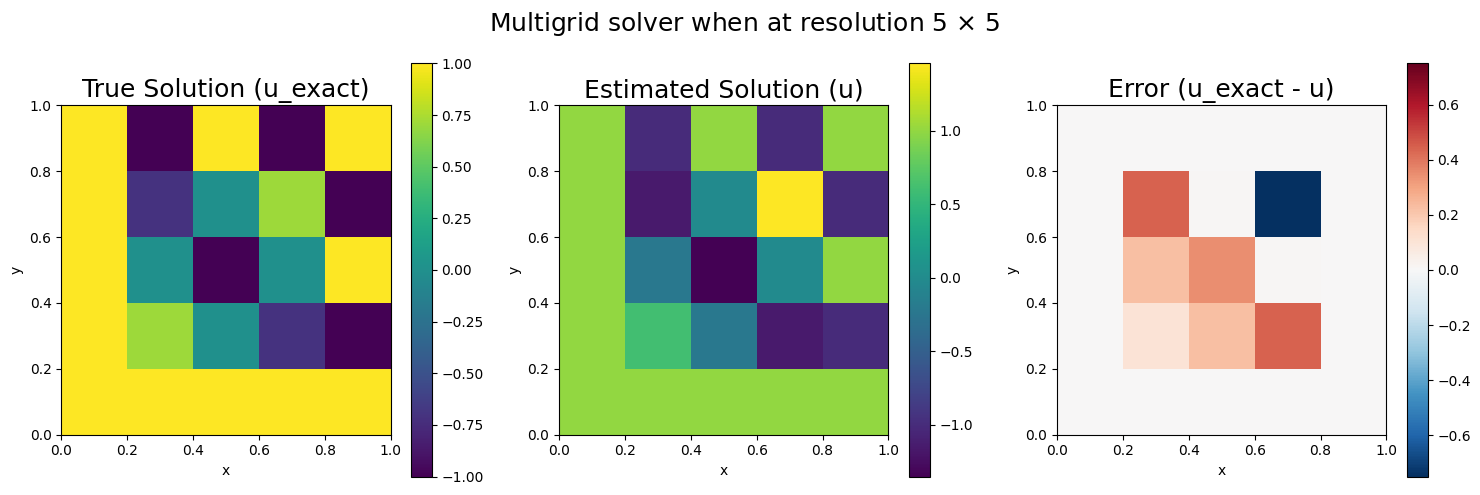

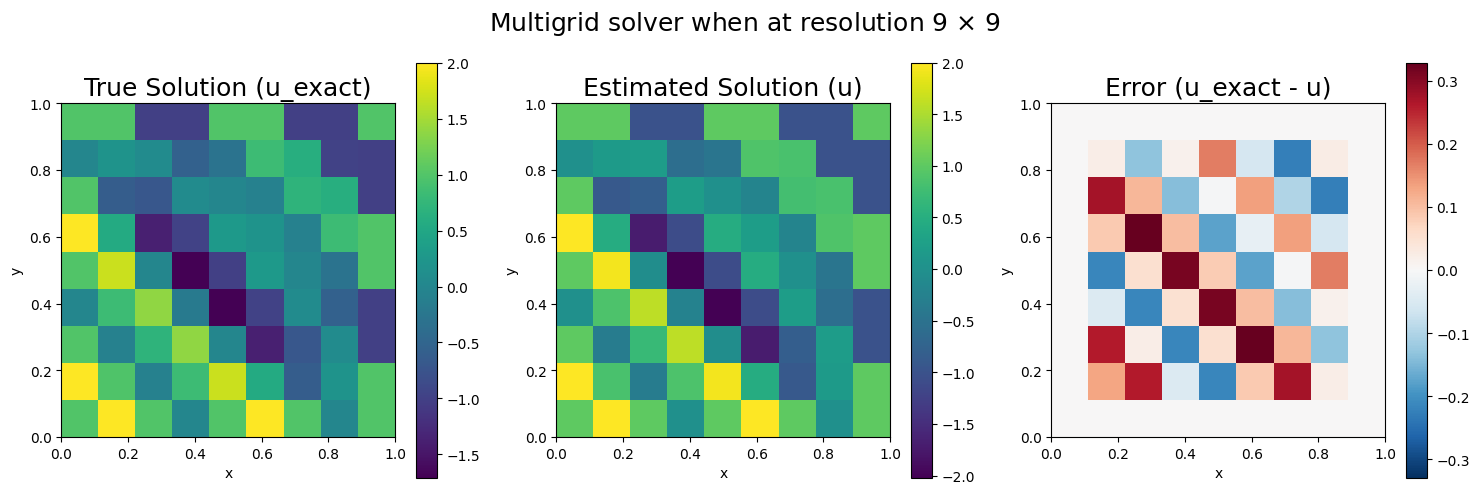

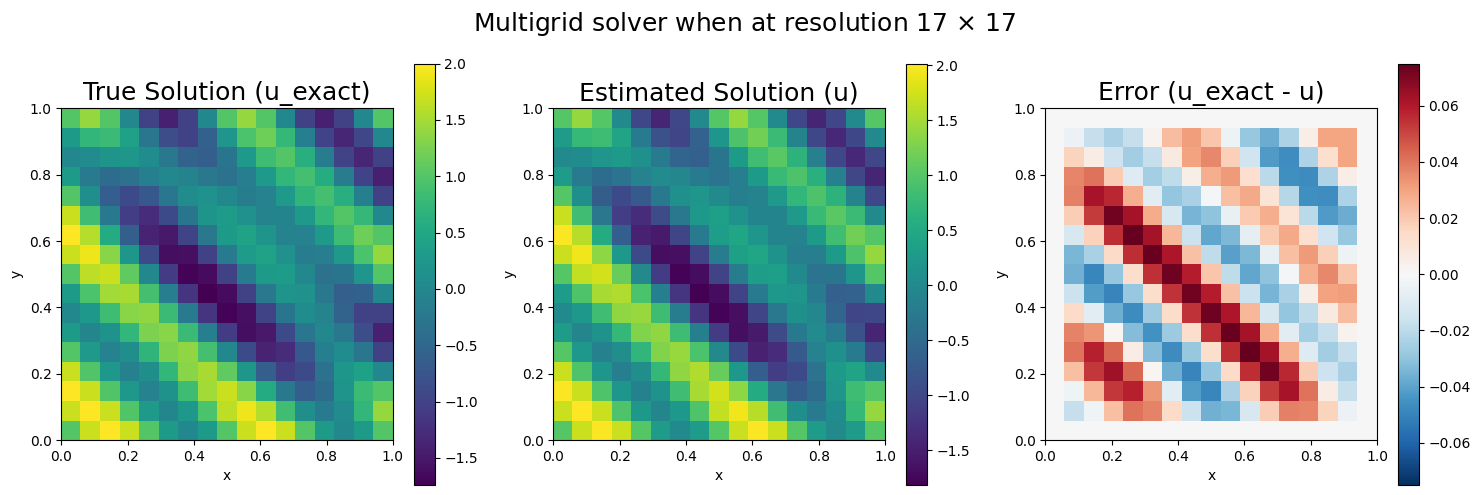

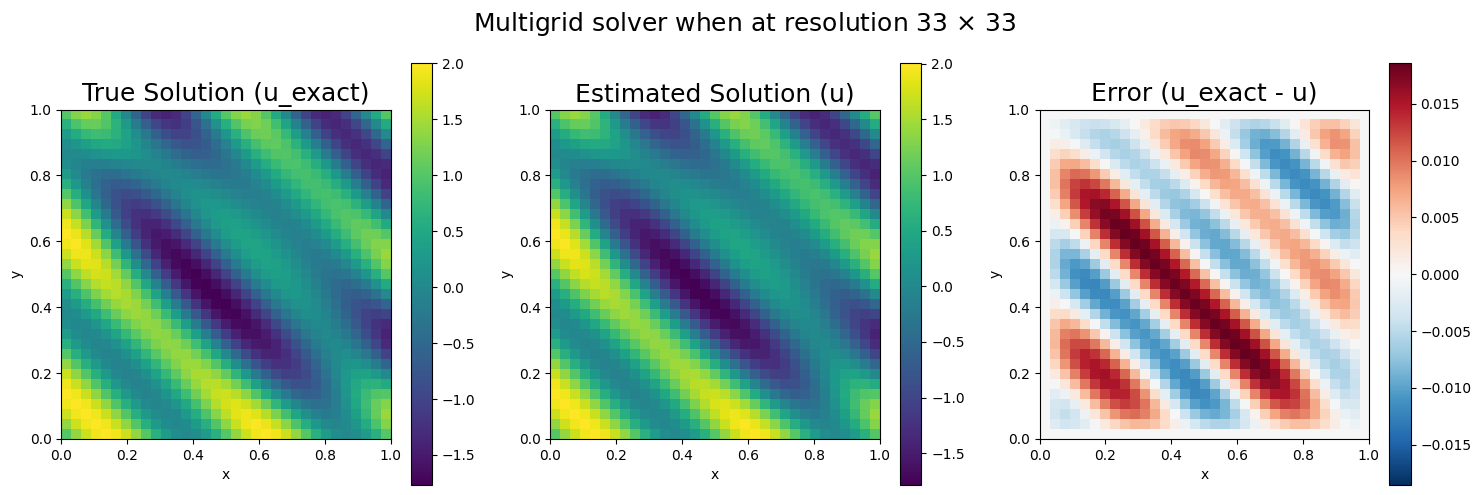

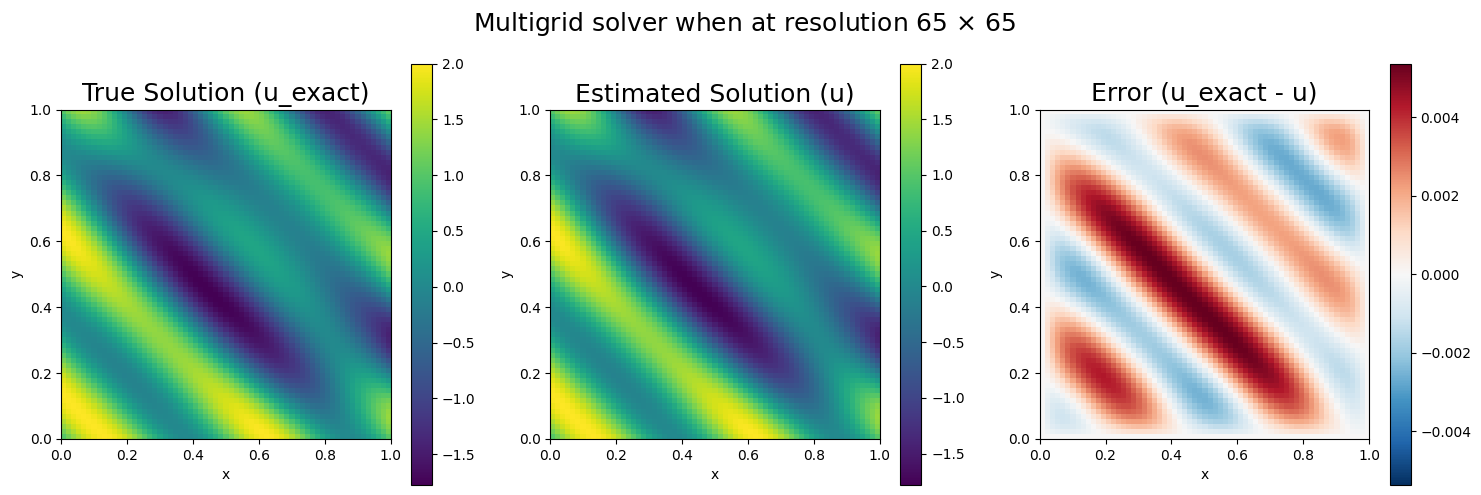

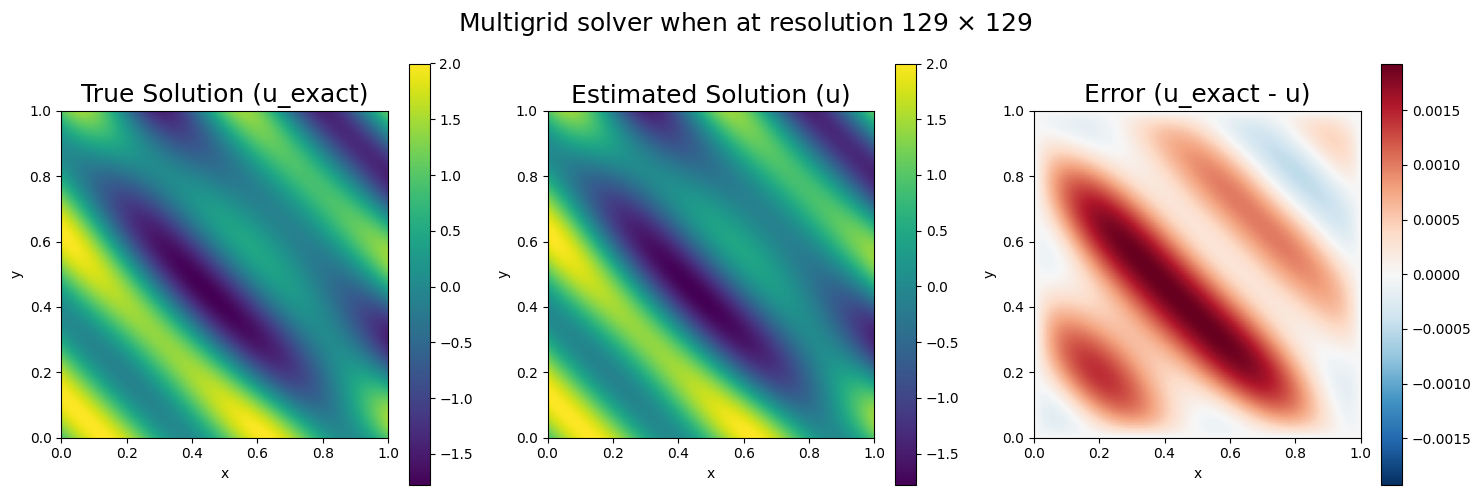

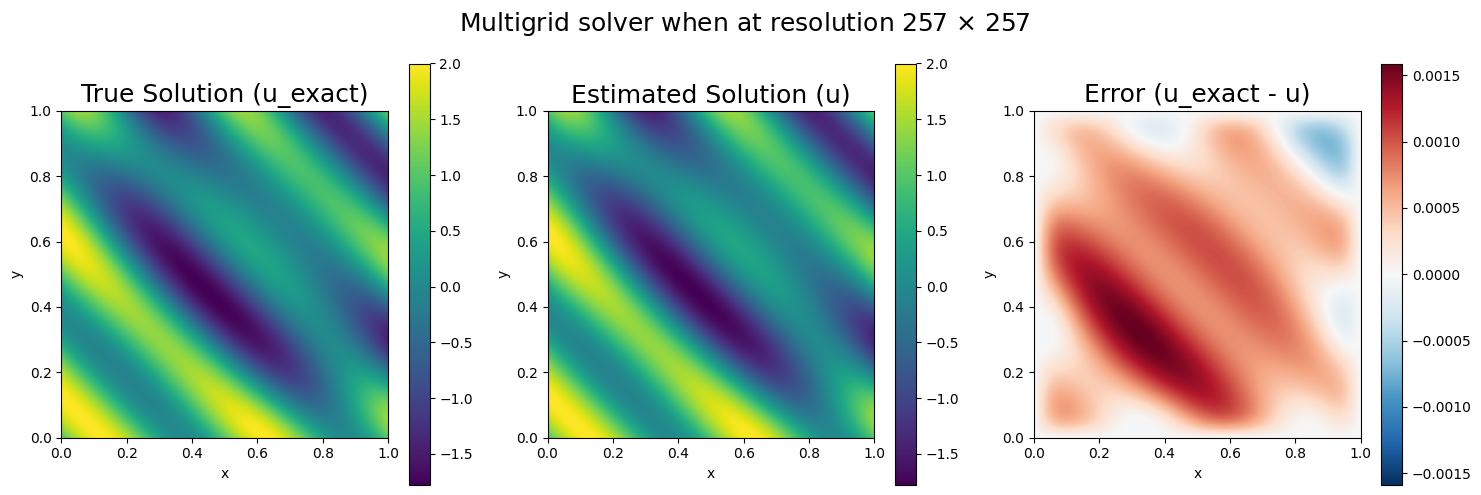

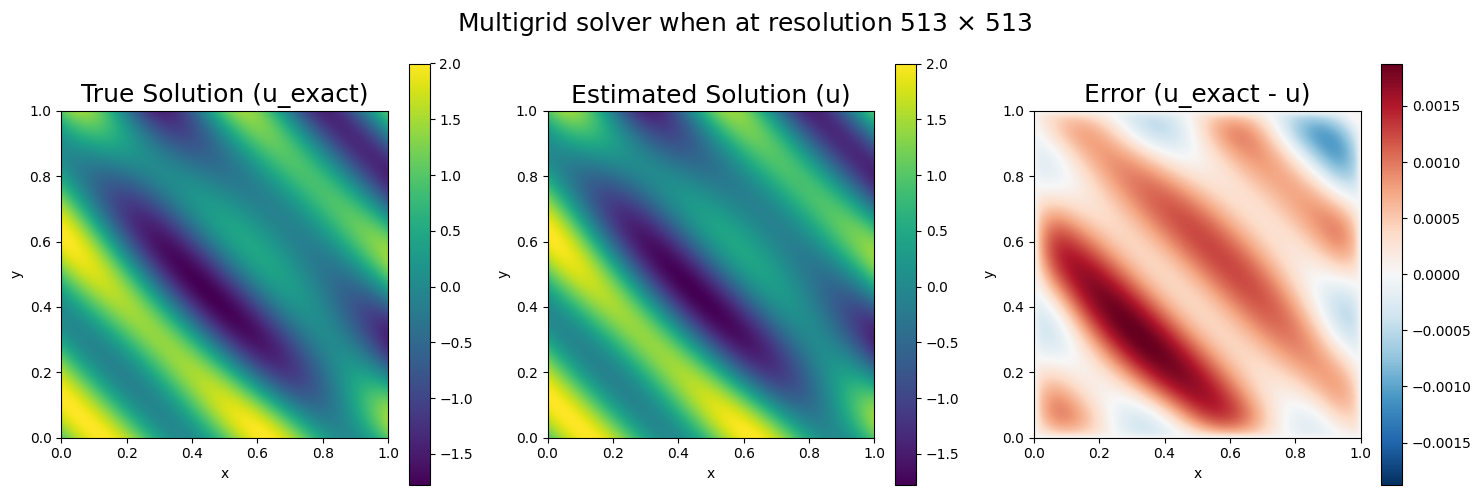

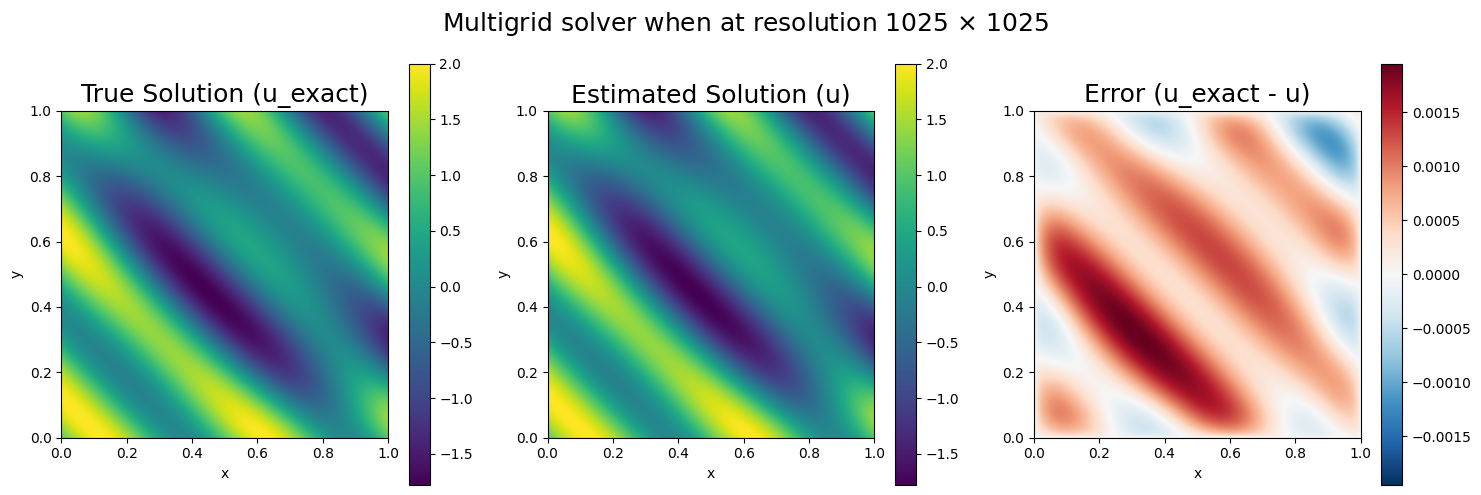

In [69]:
N = 2**10 + 1

S = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) 
S = S/4

x_vals = np.linspace(0, 1, N)
y_vals = np.linspace(0, 1, N)

# Create 2D grid
X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

# Initialize the solution grid with boundary conditions set to the true solution
u = np.zeros((N, N))  # solution grid
u[:, 0] = u_exact(x_vals, 0)  # Left boundary
u[:, -1] = u_exact(x_vals, 1)  # Right boundary
u[0, :] = u_exact(0, y_vals)  # Bottom boundary
u[-1, :] = u_exact(1, y_vals)  # Top boundary

def Vcycle(u, N):
    if N ==3:
        F = gef_f(N)[1,1]
        u[1,1] = F - (u[0,1]+ u[1,0]+u[1,2]+u[2,1])/4

    else:
        # 1.: pre-smooth u (perform <nsmooth> Jacobi iterations)
        f = gef_f(N)
        #u = Jacobi_method(u, f)
        # 3. coarsen u
        u, N = scale_down(u, N)
        # 4. recurse to Vcycle on a coarser grid
        u = Vcycle(u, N)
        # 5. interpolate u
        u, N = scale_up(u, N)
        u = convolve2d(u, S, mode = 'same') 
        vals = np.linspace(0, 1, N)
        u[:, 0] = u_exact(vals, 0)  # Left boundary
        u[:, -1] = u_exact(vals, 1)  # Right boundary
        u[0, :] = u_exact(0, vals)  # Bottom boundary
        u[-1, :] = u_exact(1, vals)  # Top boundary
        # 7.  post-smooth u (perform <nsmooth> Jacobi iterations)
        u = Jacobi_method(u, f)
        # plot 
        vals = np.linspace(0, 1, N)
        X, Y = np.meshgrid(vals, vals, indexing="ij")
        plot_Laplacian(X, Y , u, u_exact(X, Y) - u, title= f'Multigrid solver when at resolution {N} $\\times$ {N}')

    return u

u = Vcycle(u, N)
